# Regression: Linear

## References

https://www.kaggle.com/datasets/abrambeyer/openintro-possum

## Import Python Libraries

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Global Variables

In [3]:
# random state seed for repeatability
random_state = 4781

# colors
c1 = 'grey'
c2 = 'red'
c3 = 'blue'

## Import Dataset

In [4]:

# Source: https://www.kaggle.com/datasets/abrambeyer/openintro-possum

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: case: observation number
# X02: site: The site number where the possum was trapped.
# X03: Pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
# X04: sex: Gender, either m (male) or f (female).
#   y: age: Age.
# X05: hdlngth: Head length, in mm.
# X06: skullw: Skull width, in mm.
# X07: totlngth: Total length, in cm.
# X08: taill: Tail length, in cm.
# X09: footlgth: foot length
# X10: earconch: ear conch length
# X11: eye: distance from medial canthus to lateral canthus of right eye
# X11: chest: chest girth (in cm)
# X12: belly: belly girth (in cm)

In [5]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/possum.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [6]:
# identify y column
y_col = "age"

# identify X columns
cond1 = df0.columns != y_col
X_cols = df0.columns[cond1]

print(y_col)
print(X_cols)

age
Index(['case', 'site', 'Pop', 'sex', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')


In [7]:
# standardize columns names
df1 = df0.copy()
n_X_cols = len(X_cols)
leading_zeros = len(str(n_X_cols))
X_cols2 = ['X' + str(i + 1).zfill(leading_zeros) for i in range(n_X_cols)]
col_map = {X_cols[i]:X_cols2[i] for i in range(n_X_cols)}
col_map.update({y_col: 'y'})
df1 = df1.rename(columns = col_map)
df1.head()

,X01,X02,X03,X04,y,X05,X06,X07,X08,X09,X10,X11,X12,X13
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [8]:
# check data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     104 non-null    int64  
 1   X02     104 non-null    int64  
 2   X03     104 non-null    object 
 3   X04     104 non-null    object 
 4   y       102 non-null    float64
 5   X05     104 non-null    float64
 6   X06     104 non-null    float64
 7   X07     104 non-null    float64
 8   X08     104 non-null    float64
 9   X09     103 non-null    float64
 10  X10     104 non-null    float64
 11  X11     104 non-null    float64
 12  X12     104 non-null    float64
 13  X13     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


In [50]:
# update predictor columns
X_drop = ['X01']
df1 = df1.drop(columns = X_drop, errors = 'ignore')
df1.head()

,X02,X03,X04,y,X05,X06,X07,X08,X09,X10,X11,X12,X13
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [51]:
# check for missing values
df1.isna().sum()

X02    0
X03    0
X04    0
y      2
X05    0
X06    0
X07    0
X08    0
X09    1
X10    0
X11    0
X12    0
X13    0
dtype: int64

In [54]:
# remove missing values
df2 = df1.copy()
for col in df2.columns:
  # rows that are not missing
  cond = ~df2[col].isna()
  # update dataframe
  df2 = df2.loc[cond, :]

# reset index
df2 = df2.reset_index(drop = 'index')

# verify rows are all non-null same length
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X02     101 non-null    int64  
 1   X03     101 non-null    object 
 2   X04     101 non-null    object 
 3   y       101 non-null    float64
 4   X05     101 non-null    float64
 5   X06     101 non-null    float64
 6   X07     101 non-null    float64
 7   X08     101 non-null    float64
 8   X09     101 non-null    float64
 9   X10     101 non-null    float64
 10  X11     101 non-null    float64
 11  X12     101 non-null    float64
 12  X13     101 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 10.4+ KB


In [55]:
# # encode labels for categorical columns
# df3 = df2.copy()
# le = OrdinalEncoder(
#   handle_unknown = 'use_encoded_value',
#   unknown_value = -1,
#   dtype = 'int' 
# )
# label_cols = df3.select_dtypes(include = 'object').columns
# df3[label_cols] = le.fit_transform(df3[label_cols])
# df3 = df3.reindex(labels = sorted(df3.columns), axis = 1)
# df3.head()

# handle categorical columns using one-hot-encoding (one va)
df3 = df2.copy()
onehot = OneHotEncoder(handle_unknown = 'ignore', drop = 'first', dtype = 'int')
label_cols = df3.select_dtypes(include = 'object').columns
df_temp = pd.DataFrame(onehot.fit_transform(df3[label_cols]).toarray())
df_temp.columns = onehot.get_feature_names_out()
df3 = pd.concat([df3, df_temp], axis = 1).drop(columns = label_cols, errors = 'ignore')
df3 = df3.reindex(labels = sorted(df3.columns), axis = 1)
df3.head()

,X02,X03_other,X04_m,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,1,0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,8.0
1,1,0,0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,6.0
2,1,0,0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,6.0
3,1,0,0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,6.0
4,1,0,0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,2.0


In [56]:
# check data types
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X02        101 non-null    int64  
 1   X03_other  101 non-null    int32  
 2   X04_m      101 non-null    int32  
 3   X05        101 non-null    float64
 4   X06        101 non-null    float64
 5   X07        101 non-null    float64
 6   X08        101 non-null    float64
 7   X09        101 non-null    float64
 8   X10        101 non-null    float64
 9   X11        101 non-null    float64
 10  X12        101 non-null    float64
 11  X13        101 non-null    float64
 12  y          101 non-null    float64
dtypes: float64(10), int32(2), int64(1)
memory usage: 9.6 KB


In [57]:
# new X cols
y_col3 = col_map[y_col]
cond1 = df3.columns != y_col3
X_cols3 = df3.columns[cond1]
X_cols3

Index(['X02', 'X03_other', 'X04_m', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13'],
      dtype='object')

In [58]:
# normalize data in X columns
df4 = df3.copy()
norm = StandardScaler()
df4[X_cols3] = norm.fit_transform(X = df4[X_cols3])
df4.head()

,X02,X03_other,X04_m,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,-1.135075,-1.161395,0.843721,0.391091,1.114121,0.414441,-0.534944,1.389467,1.575748,0.141928,0.465334,1.238441,8.0
1,-1.135075,-1.161395,-1.185227,-0.065889,0.207174,1.013103,-0.280089,0.934052,0.758956,0.901381,0.714004,0.133146,6.0
2,-1.135075,-1.161395,-1.185227,0.362530,0.984557,1.970964,0.994189,1.594404,0.932215,0.426723,1.460016,0.501578,6.0
3,-1.135075,-1.161395,-1.185227,0.134040,0.045219,1.132836,0.484478,1.753799,1.006469,0.141928,0.465334,0.501578,6.0
4,-1.135075,-1.161395,-1.185227,-0.351501,-0.213909,-0.423687,-0.534944,0.592490,1.253981,0.046996,0.714004,0.133146,2.0


## Train and Test ML Model

In [84]:
# Split data into X, y
X = df4[X_cols3]
y = df4[y_col3]

In [65]:
# number of subplot columns
ncols = 4

# number of subplot rows
nrows = np.ceil(len(X.columns) / ncols).astype('int')

# subplot figure width
fwidth = 6 * ncols

# subplot figure height
fheight = 5 * nrows

# ymin
y_min = y.min() - 1

# ymax
y_max = y.max() + 1

# X_min
X_max = X.max().max() + 1

# X_min
X_min = X.min().min() - 1

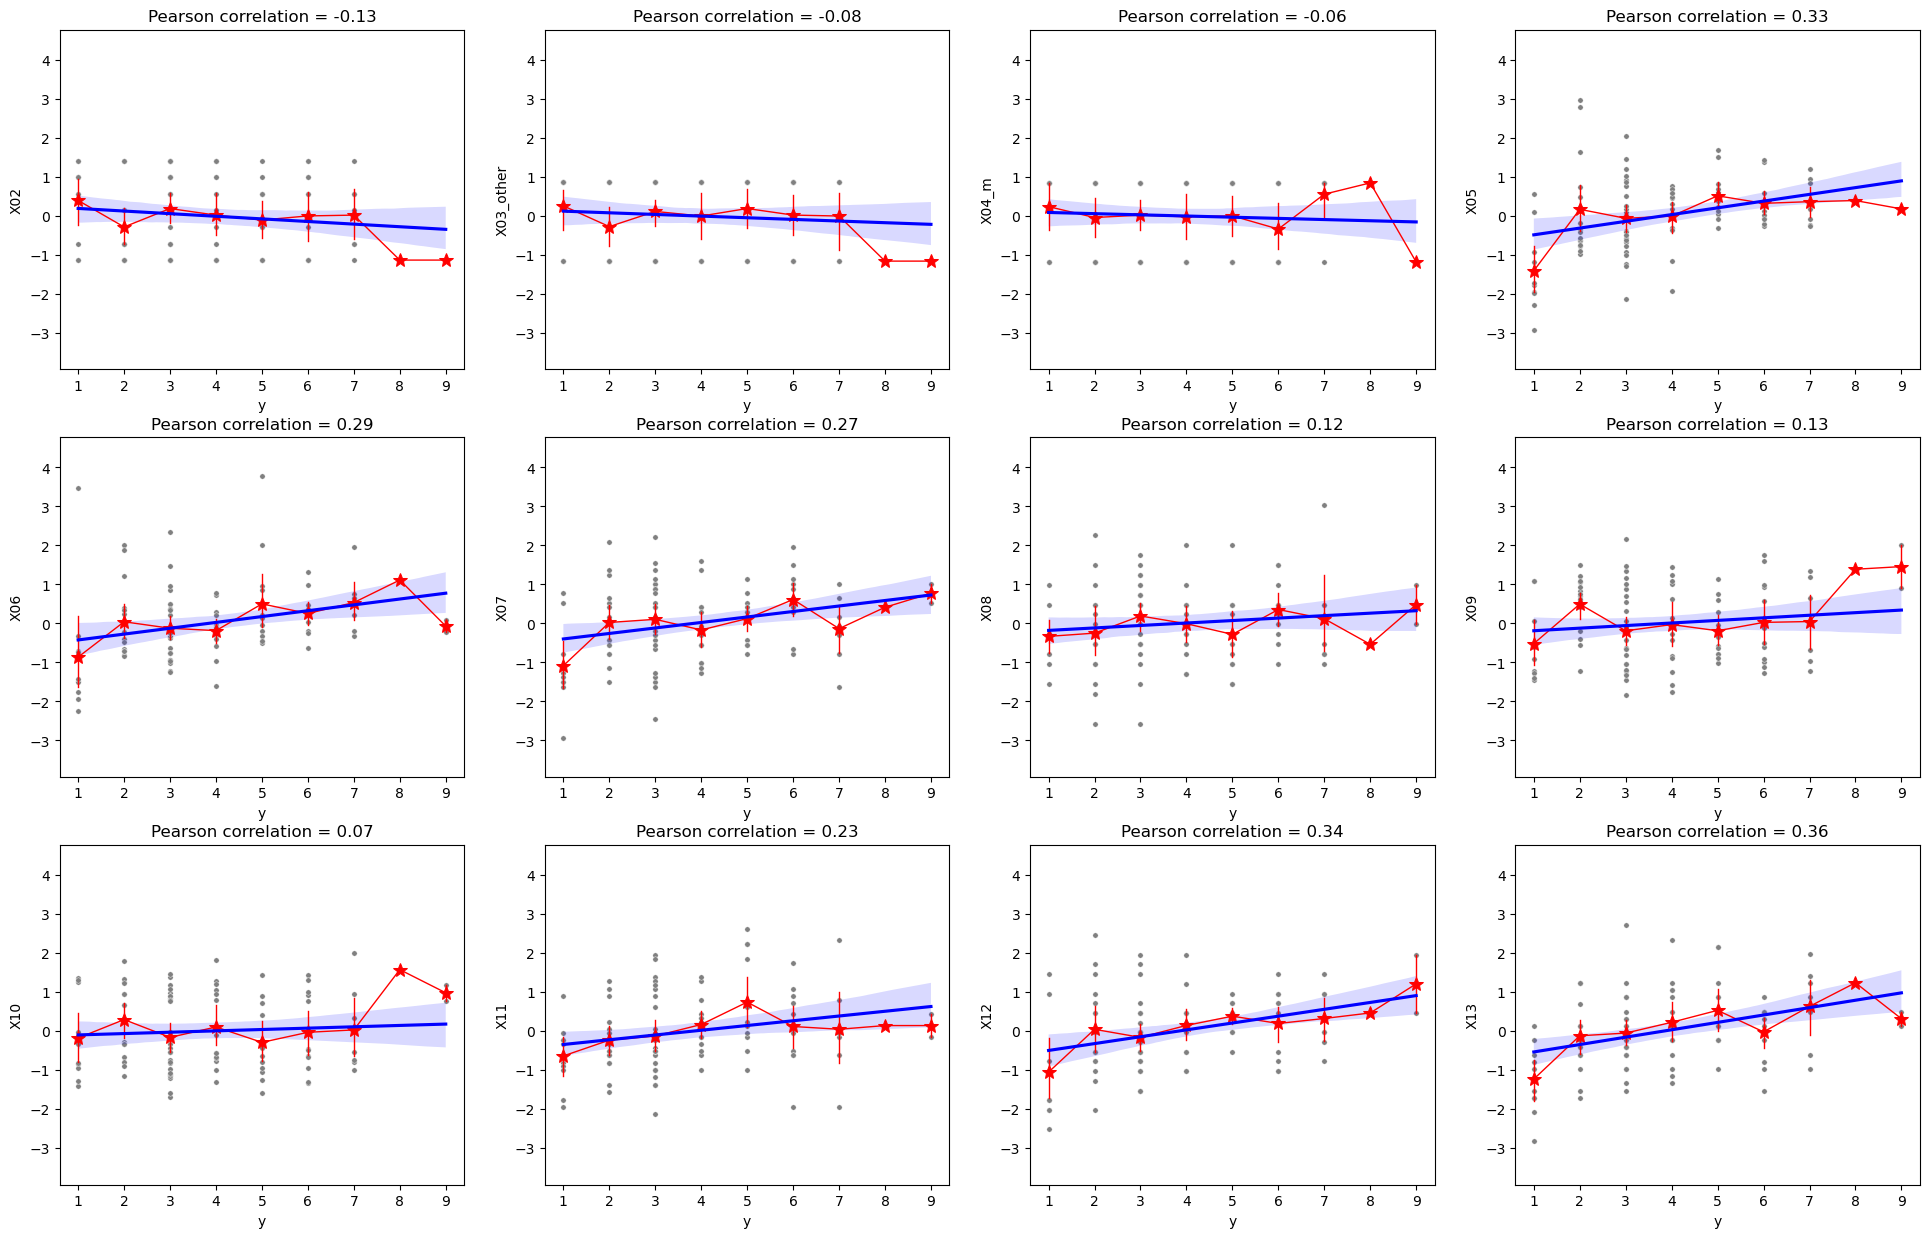

In [66]:
# check assumption 1: linear relationship (scatter)

# config super axis for the subplots
f1, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (fwidth, fheight))

# force axes to be 2-D
axes = axes.reshape((nrows, ncols))

for i in range(len(X.columns)):
  col = X.columns[i]
  col_i = np.mod(i, ncols).astype('int')
  row_i = np.floor(i / ncols).astype('int')
  
  # plot scatter plots
  p1 = sns.scatterplot(ax = axes[row_i, col_i], y = X[col], x = y, marker = 'o',  s = 15, color = c1)
  
  # add main effects line
  p2 = sns.pointplot(ax = axes[row_i, col_i], y = X[col], x = y, native_scale=True, marker = '*', color = c2, linewidth = 1.0, markersize = 10)
  p2.set_ylim((X_min, X_max))
  
  # add regression line
  p3 = sns.regplot(ax = axes[row_i, col_i], y = X[col], x = y, marker = '', color = c3, ci = 95)
  
  # add correlation coefficient between X and y
  r = np.round(X[col].corr(y), 2)
  txt  = f"Pearson correlation = {r}"
  p3.set_title(txt)

plt.show()

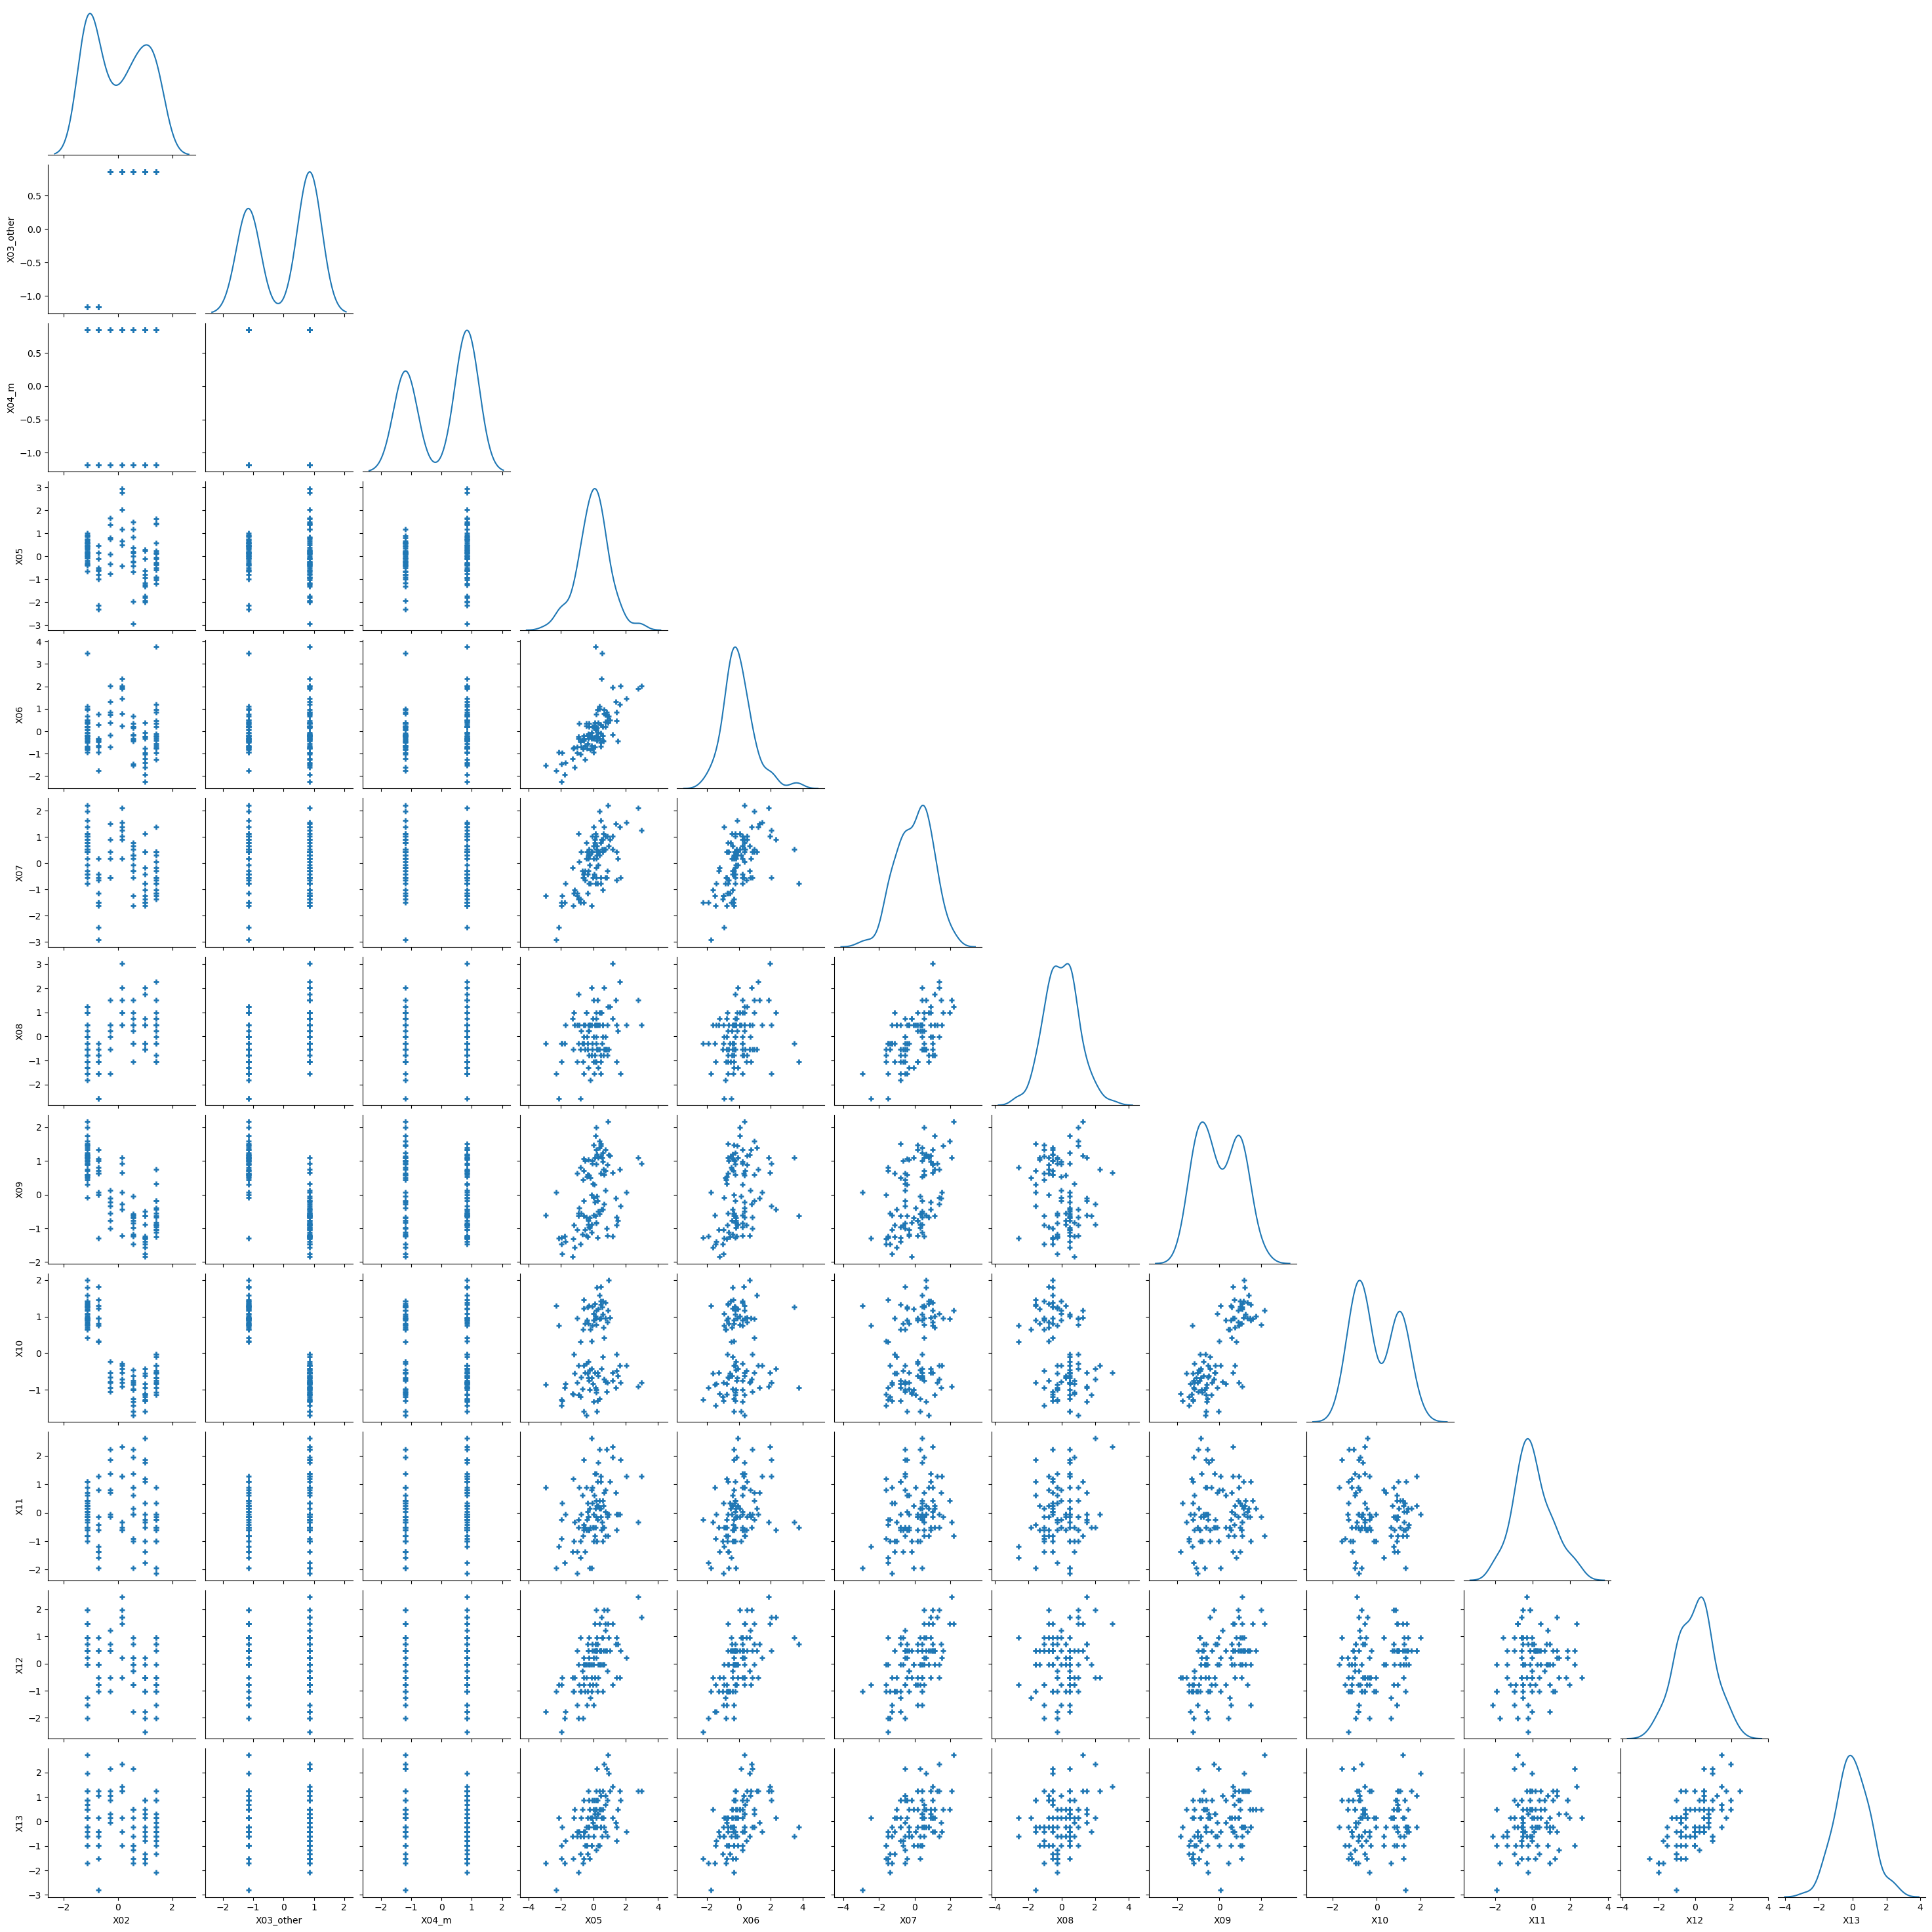

In [67]:
# check assumption 2: little or No Multi-Collinearity (approach 1)
p1 = sns.pairplot(data = X, corner = True, diag_kind="kde", diag_kws = dict(fill = False), plot_kws = dict(marker = "+", linewidth = 2))
plt.show()

In [68]:
# check assumption 2: little or No Multi-Collinearity (approach 2)
corr_threshold = 0.8
r = X.corr()
r.loc[:,:] = np.tril(r,0)
cond = np.where((abs(r) > corr_threshold) & (r != 1))
i = cond[0]
j = cond[1]
x_vars = r.index[i]
y_vars = r.columns[j]
r_values = [r.iloc[i[ii], j[ii]].round(2) for ii in range(len(i))]
check_vars = [(x_vars[i], y_vars[i], r_values[i]) for i in range(len(x_vars))]
check_vars

[('X03_other', 'X02', 0.89),
 ('X10', 'X02', -0.82),
 ('X10', 'X03_other', -0.93)]

In [86]:
# check assumption 2: little or No Multi-Collinearity (approach 3)
# iterate removing high VIF Xs until all VIF values are less than 5
X_temp = X.copy()
df_vif = pd.DataFrame()
# X_drop = ['X03_other']
X_drop = ['X03_other', 'X02']
X_include = X_temp.columns[~X_temp.columns.isin(X_drop)]
df_vif['X'] = X_include
df_vif['VIF'] = [variance_inflation_factor(X[X_include], i) for i in range(len(df_vif['X']))]
df_vif

,X,VIF
0,X04_m,1.234045
1,X05,3.274139
2,X06,2.346808
3,X07,3.938731
4,X08,2.481981
5,X09,4.147671
6,X10,3.691394
7,X11,1.273534
8,X12,2.556613
9,X13,1.847366


In [87]:
# train test split data
X_train, X_test, y_train, y_test = train_test_split(X_temp, y,
 test_size = 0.7, 
 shuffle = True,
 random_state = random_state
)

In [123]:
# fit regression model
my_fit = LinearRegression()
my_fit.fit(X_train, y_train)

LinearRegression()

In [131]:
# get predicted values
y_hat = my_fit.predict(X_test).round(0)
y_hat

array([ 3.,  5.,  6.,  4.,  4.,  5.,  5.,  0.,  2.,  1.,  5.,  5.,  6.,
        3.,  2.,  7.,  6.,  7.,  2.,  3.,  1.,  2.,  7.,  1.,  4., -0.,
        4.,  4.,  4.,  6.,  6.,  3.,  4.,  2.,  4.,  7.,  8.,  3.,  4.,
        0.,  7.,  5.,  2.,  3.,  2.,  2.,  5.,  5.,  3.,  5.,  1.,  4.,
        8.,  5.,  2.,  6.,  4.,  6.,  5.,  4.,  3.,  3.,  5.,  1.,  4.,
        2.,  4.,  5.,  3.,  4.,  2.])

In [132]:
r2_score(y_true = y_test, y_pred = y_hat)

-0.9017857142857146

In [89]:
# check assumption 3: little or no autocorrelation


In [ ]:
# check assumption 4: no outliers 

In [ ]:
# check assumption 5: homoscedasticity (equal variance)